## Combining and Cleaning All Headlines Dataset for modeling
real news = 0, fake news = 1

In [1]:
import nltk
import string

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import plotly.express    as px

from matplotlib import cm
from tqdm       import tqdm
from wordcloud  import WordCloud

from nltk.probability import FreqDist
from nltk.corpus      import stopwords
from nltk.tokenize    import sent_tokenize, word_tokenize
from nltk.stem        import PorterStemmer, WordNetLemmatizer

from sklearn         import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, make_scorer, accuracy_score

from sklearn.preprocessing           import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection         import train_test_split, GridSearchCV

from sklearn.naive_bayes   import MultinomialNB, GaussianNB
from sklearn.ensemble      import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble      import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.svm           import SVC

np.random.seed(0)

## Combining All Datasets

In [2]:
esocinfo = pd.read_csv('Data/Headlines/ESOCheadlines_eng.csv')
zenodoinfo = pd.read_csv('Data/Headlines/Zenodoheadlines.csv')
fakeinfo = pd.read_csv('Data/Headlines/fakeheadlines.csv')
trueinfo = pd.read_csv('Data/Headlines/trueheadlines.csv')
sarcasminfo = pd.read_csv('Data/Headlines/sarc_headlines.csv')

In [3]:
df = pd.concat([esocinfo, zenodoinfo, fakeinfo, trueinfo, sarcasminfo], ignore_index=True)
df

,headline,real_or_fake
0,India Is In The Middle Of A Coronavirus YouTub...,1
1,"Tweet: False reporting on ""shooting down"" peop...",1
2,"Tweet: A woman eating a delicacy, attributing ...",1
3,Tweet: False chain message about NYPD containm...,1
4,Hoax Alert: Viral 'Emergency Notification' On ...,1
...,...,...
111923,jews to celebrate rosh hashasha or something,1
111924,internal affairs investigator disappointed con...,1
111925,the most beautiful acceptance speech this week...,0
111926,mars probe destroyed by orbiting spielberg-gat...,1


In [4]:
df.real_or_fake.value_counts()

0    61114
1    50814
Name: real_or_fake, dtype: int64

In [6]:
df.to_csv('all_headlines.csv', index=False)

In [5]:
data = df['headline']
target = df['real_or_fake']

processed_data = [d.split() for d in data.to_list()]

lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [6]:
X_lem = lemmatized_output
y_lem = target

In [4]:
sw_list  = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '27', '1', "'ve",
            '-', '–', '—', "n't", 'https', '2', "'re", "'m'", '3', '..', 'ca', "'s", 'amp']

## TFIDF Vectorization

### Keeping all rows but Maximum Features after vectorization: 5000

In [8]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)

tfidf = TfidfVectorizer(stop_words=sw_list, max_features=5000)
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem  = tfidf.transform(X_test_lem)

#### Average Number Of Elements And Matrix Sparsity

In [9]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Text: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Text: 6.913180406959863
Percentage of columns containing ZERO: 0.998617363918608


### Dense Data

In [10]:
train = tfidf_data_train_lem.toarray()
test  = tfidf_data_test_lem.toarray()

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)
X_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca['Target'] = y_lem

Text(0.5, 1.0, 'Data Separability')

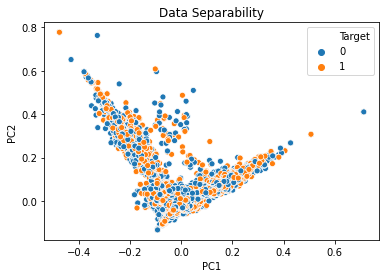

In [15]:
sns.scatterplot(x=X_pca['PC1'], y=X_pca['PC2'],
                hue=X_pca['Target']).set_title('Data Separability')

In [18]:
gnb = GaussianNB()

gnb.fit(train, y_train_lem)


gnb_train_preds_lem = gnb.predict(train)
gnb_test_preds_lem  = gnb.predict(test)

print(classification_report(y_train_lem, gnb_train_preds_lem))
print(classification_report(y_test_lem, gnb_test_preds_lem))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     48932
           1       0.80      0.72      0.76     40610

    accuracy                           0.79     89542
   macro avg       0.79      0.79      0.79     89542
weighted avg       0.79      0.79      0.79     89542

              precision    recall  f1-score   support

           0       0.77      0.84      0.80     12182
           1       0.78      0.70      0.74     10204

    accuracy                           0.77     22386
   macro avg       0.78      0.77      0.77     22386
weighted avg       0.77      0.77      0.77     22386



In [19]:
rf = RandomForestClassifier(random_state=123)

rf.fit(train, y_train_lem)

rf_train_preds_lem = rf.predict(train)
rf_test_preds_lem = rf.predict(test)

print(classification_report(y_train_lem, rf_train_preds_lem))
print(classification_report(y_test_lem, rf_test_preds_lem))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48932
           1       1.00      1.00      1.00     40610

    accuracy                           1.00     89542
   macro avg       1.00      1.00      1.00     89542
weighted avg       1.00      1.00      1.00     89542

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     12182
           1       0.93      0.88      0.91     10204

    accuracy                           0.92     22386
   macro avg       0.92      0.92      0.92     22386
weighted avg       0.92      0.92      0.92     22386



In [16]:
svc = SVC(kernel='sigmoid', C=100)

svc.fit(train, y_train_lem)
svc_train_preds_lem = svc.predict(train)
svc_test_preds_lem = svc.predict(test)

print(classification_report(y_train_lem, svc_train_preds_lem))
print(classification_report(y_test_lem, svc_test_preds_lem))

              precision    recall  f1-score   support

           0       0.69      0.70      0.69     48932
           1       0.63      0.63      0.63     40610

    accuracy                           0.67     89542
   macro avg       0.66      0.66      0.66     89542
weighted avg       0.67      0.67      0.67     89542

              precision    recall  f1-score   support

           0       0.75      0.76      0.75     12182
           1       0.71      0.70      0.70     10204

    accuracy                           0.73     22386
   macro avg       0.73      0.73      0.73     22386
weighted avg       0.73      0.73      0.73     22386



## Sample of 10000 Rows of the All Headlines Dataset

In [5]:
df_sample10 = df.sample(n=10000, random_state=123)


df_sample10.real_or_fake.value_counts()

df_sample10.reset_index(inplace=True, drop=True)
df_sample10

,headline,real_or_fake
0,10 notable books of 2016 on black women's history,0
1,'breitbart' refusing to release names of mass ...,1
2,THE VIEW WOMEN Go Off The Rails: Trump ‘has to...,1
3,Top Democrat says he hopes U.S. Senate at turn...,0
4,a great read for a new year,0
...,...,...
9995,Number of deaths by COVID-19 fell in the state...,0
9996,cool ashtray found,1
9997,mitch mcconnell says elections are 'not an exc...,0
9998,poor attendance at intervention a real wake-up...,1


In [6]:
data10 = df_sample10['headline']
target10 = df_sample10['real_or_fake']

processed_data10 = [d.split() for d in data10.to_list()]

lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data10:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

X_lem10 = lemmatized_output
y_lem10 = target10

## TFIDF Vectorization - 10000 Row Sample

### Keeping all rows but Maximum Features after vectorization: 5000

In [7]:
X_train_lem10, X_test_lem10, y_train_lem10, y_test_lem10 = train_test_split(X_lem10, y_lem10, test_size=0.20, random_state=1)

tfidf10 = TfidfVectorizer(stop_words=sw_list, max_features=5000)
tfidf_data_train_lem10 = tfidf10.fit_transform(X_train_lem10)
tfidf_data_test_lem10  = tfidf10.transform(X_test_lem10)

#### Average Number Of Elements And Matrix Sparsity

In [8]:
non_zero_cols10 = tfidf_data_train_lem10.nnz / float(tfidf_data_train_lem10.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Text: {}".format(non_zero_cols10))

percent_sparse10 = 1 - (non_zero_cols10 / float(tfidf_data_train_lem10.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse10))

Average Number of Non-Zero Elements in Vectorized Text: 7.112
Percentage of columns containing ZERO: 0.9985776


### Dense Data - 10000 Rows Sample

In [9]:
train10 = tfidf_data_train_lem10.toarray()
test10  = tfidf_data_test_lem10.toarray()

## Random Forest gridsearch parameters setup

In [10]:
rf_params = {'n_estimators': [100,200], 'criterion':['gini', 'entropy'],
           'oob_score':['True', 'False'], 'max_depth':[10,15,20]}

### RandomForest GridSearchCV

In [15]:
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, scoring='f1_weighted',
                      return_train_score=True, verbose=1, n_jobs=-1)

rf_grid.fit(train10, y_train_lem10)

rf_grid_train_preds = rf_grid.predict(train10)
rf_grid_test_preds = rf_grid.predict(test10)

print('\033[1m' + 'Random Forest Classifier Train Report:\n' + '\033[0m')
print(classification_report(y_train_lem10, rf_grid_train_preds))
print('\033[1m' + 'Random Forest Classifier Test Report:\n' + '\033[0m')
print(classification_report(y_test_lem10, rf_grid_test_preds))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Random Forest Classifier Train Report:

              precision    recall  f1-score   support

           0       0.68      0.98      0.81      4383
           1       0.96      0.45      0.61      3617

    accuracy                           0.74      8000
   macro avg       0.82      0.72      0.71      8000
weighted avg       0.81      0.74      0.72      8000

Random Forest Classifier Test Report:

              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1119
           1       0.89      0.45      0.60       881

    accuracy                           0.73      2000
   macro avg       0.79      0.70      0.70      2000
weighted avg       0.78      0.73      0.71      2000



Random Forest Classifier Train Data Confusion Matrix:



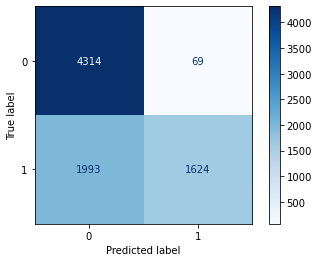

Random Forest Classifier Test Data Confusion Matrix:



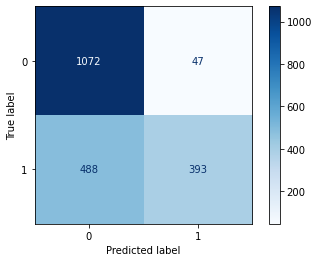

In [16]:
print('\033[1m' + 'Random Forest Classifier Train Data Confusion Matrix:\n')
plot_confusion_matrix(rf_grid, tfidf_data_train_lem10, y_train_lem10, cmap=plt.cm.Blues)
plt.show()
print('\033[1m' + 'Random Forest Classifier Test Data Confusion Matrix:\n')
plot_confusion_matrix(rf_grid, tfidf_data_test_lem10, y_test_lem10, cmap=plt.cm.Blues)
plt.show()